> __Purpose:__ 

- The x axis is really starting from update 10 (or 9?) in the code!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
import os
import h5py
import copy
import statistics

import seaborn as sns

#from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import re

#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

In [2]:
final_update = 16

## Load Data

In [50]:
cv_results_path = base_path+r'\09-19_23-07_PFAFO_GDLS'
filename = 'GDLS_PFAFO_GDLS_KFold'

for i in range(1):
    h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")    
    # Load data from HDF5 file
    with h5py.File(h5_path, 'r') as f:
        a_group_key = list(f.keys())
        print(a_group_key)

['client_local_model_log', 'client_local_test_log', 'global_dec_log', 'global_test_error_log', 'global_train_error_log', 'gradient_norm_lists_by_client', 'local_test_error_log', 'local_train_error_log']


In [77]:
def load_final_model_performances(cv_results_path, filename, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            a_group_key = list(f.keys())
            #if i==0:
            #    print(a_group_key)
            for key in a_group_key:
                #print(key)
        
                if key=="client_local_model_log":
                    client_keys = list(f[key])
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
    
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                elif key=="global_dec_log" and "NOFL" not in filename:
                    # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                else:
                    pass

    return extraction_dict


In [78]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSims'
base_path = results_path + current_directory

# CROSS
cpfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
cfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold')
cnofl_model_dict = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
ifa_model_dict = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold')
inofl_model_dict = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold')


# Adversarial Modeling

In [79]:
# LinearSVC() --> Was failling to converge...

In [105]:
def execute_linkage_attack(extractration_dict, num_kfolds=0, i_modulus=3, i_lt_or_eq='eq', 
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, min_n_samples=10, num_clients=14):

    flattened_input_df, num_updates = create_linkage_attack_df(extractration_dict, num_clients=num_clients)

    local_res_df = execute_local_linkage_attack(flattened_input_df, num_updates, num_kfolds=num_kfolds, i_modulus=i_modulus, i_lt_or_eq=i_lt_or_eq,
                           my_models_list=my_models_list, make_df=make_df, min_n_samples=min_n_samples, num_clients=num_clients)

    global_res_df = execute_global_linkage_attack(flattened_input_df, num_updates, i_modulus=i_modulus, i_lt_or_eq=i_lt_or_eq,
                           my_models_list=my_models_list, make_df=make_df, min_n_samples=min_n_samples, num_clients=num_clients)

    return local_res_df, global_res_df

    
def create_linkage_attack_df(extractration_dict, num_clients=14):

    keys = extractration_dict.keys()
    num_updates_lst = []
    for key in keys:
        if "global" in key:
            continue
        num_updates_lst.append(len(extractration_dict[key]))
    mode_update = statistics.mode(num_updates_lst)
    max_update = max(num_updates_lst)
    # ^ NOW THAT GLOVAL IS INCLUDED, MAX UPDATE IS WAY OFF FOR LOCAL!
    ## Could find the 2nd largest value, since all global runs will have the same length...
    if max_update == mode_update:  # Eg this is a poor man's proxy for if this is the NOFL case
        num_updates = mode_update
    else:
        num_updates = min(max_update, int(statistics.mean(num_updates_lst) + np.sqrt(statistics.stdev(num_updates_lst))))  # int() rounds down
        # np.sqrt(stdev) bc sometimes stdev is massive (like 38), making num_updates just equal to the max...
    print(f"num updates = {num_updates}; max_update {max_update}; avg_num_updates {statistics.mean(num_updates_lst)}")
    
    # Initialize a list of empty DataFrames for each user group
    dec_flattened_list = [pd.DataFrame(columns=['Subject', 'Fold', 'Update Number', 'Flattened Dec']) for _ in range(num_updates)]
    global_dec_flattened_list = [pd.DataFrame(columns=['Subject', 'Fold', 'Update Number', 'Flattened Dec']) for _ in range(max_update)]
    
    # Regular expression pattern to extract subject and fold
    #pattern = r"S(\d+)_client_local_model_log_fold(\d+)"
    #pattern = r"(S\d+)_client_local_model_log_fold(\d+)"
    pattern = r"((S\d+)_client_local_model_log_fold(\d+)|global_dec_log_fold(\d+))"
    # Loop through keys and updates to populate the DataFrames
    for key_idx, key in enumerate(keys):
        key_len = len(extractration_dict[key])
        match = re.search(pattern, key)  # Extract the subject and fold using regex
        # Group0: Entire match (the entire local key? Not sure what happens if global is the match...)
        # Group1: Local subject ID (str)
        # Group3: Local fold
        # Group4: Global fold
        if match:
            if match.group(2):
                #print(f"Group 1: {match.group(1)}")
                #print(f"Group 2: {match.group(2)}")
                #print(f"Group 3: {match.group(3)}")
                subject = match.group(1)  # e.g., 'S0', 'S1', 'S10'
                fold = int(match.group(3))  # e.g., '0', '1', '2'
                for update_number in range(num_updates): 
                    if update_number >= key_len:
                        continue
                    else:
                        user_data = np.ravel(extractration_dict[key][update_number])
                        dec_flattened_list[update_number].loc[len(dec_flattened_list[update_number])] = [subject, fold, update_number, user_data]
            elif match.group(4):  # This means it's a 'global_dec_log_fold(\d+)' key
                #print(f"Group 4: {match.group(4)}")
                fold = int(match.group(4))
                for update_number in range(max_update): # Max_update will be the number of global rounds
                    global_data = np.ravel(extractration_dict[key][update_number])
                    for subj_ID_num in range(num_clients):
                        global_dec_flattened_list[update_number].loc[len(global_dec_flattened_list[update_number])] = ["S"+str(subj_ID_num), fold, update_number, global_data]
    
    # Concat all the dfs into a single training input dataframe
    dec_flattened = pd.concat(dec_flattened_list, ignore_index=True, axis=0)
    flattened_input_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
    return flattened_input_df, num_updates


def execute_local_linkage_attack(flattened_input_df, num_updates, num_kfolds=0, i_modulus=3, i_lt_or_eq='eq', 
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, min_n_samples=10, num_clients=14):
    my_metrics_columns=['Adversarial Model', 'Update Number', 'CV Acc', 'Test Acc']
    full_test_res_df = pd.DataFrame(columns=my_metrics_columns)
    
    # Adjust stop index to prevent overflow
    n_start_stop=(0, num_updates)
    n_stop = n_start_stop[1] - 1
    print(f"num_updates {num_updates}; n_start_stop {n_start_stop}; new n_stop {n_stop}")
    
    for i in range(n_start_stop[0], n_stop + 1):
        #print(f"Round i={i} of stop={n_start_stop[1]}")
    
        if make_df:
            #print("Making custom test set, NOT USING PASSED IN full_test_df")
    
            if i%i_modulus==0:
                print(f"Round i={i} of stop={n_start_stop[1]}")
                
                # Filter the dataframe to use data from updates <= i
                # TODO: DECIDE ON USING <, <=, OR BOTH!
                if i_lt_or_eq == 'lt':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] <= i]
                elif i_lt_or_eq == 'eq':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] == i]
                test_df = flattened_input_df[flattened_input_df['Update Number'] >= n_stop]  
                # Hold out the last update for testing
                ## Actually, I changed it to use ALL updates greater than the final train update (which is close to the mean...)
            else:
                # SKIP THE ENTIRE LOOP
                #print(f"{i} skipped for speed!")
                continue
        else:
            raise ValueError('Need to set train_df somehow...: for now, only use make_df=True')
        
        X_test = test_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_test = test_df['Subject']
    
        # Explicitly use the 'Fold' column for cross-validation
        for model in my_models_list:
            if num_kfolds == 0:
                #print(f"Fold {fold_num}")
                train_fold = train_df#[train_df['Fold'] != fold_num]
                #val_fold = train_df[train_df['Fold'] == fold_num]
    
                if train_fold.shape[0] < min_n_samples: 
                    print(f"Not enough samples! Skipping this round")
                    continue
                #elif val_fold.shape[0]==0:
                #    # Clients are trained a different number of rounds, so the max may be much higher than the average
                #    # Thus resulting in upper rounds not containing any instances of a specific fold (eg can't train the model the way it is expected here)
                #    continue

                X_train_fold = train_fold.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
                y_train_fold = train_fold['Subject'].reset_index(drop=True)
                #X_val_fold = val_fold.drop(columns=['Subject', 'Fold', 'Update Number'])
                #y_val_fold = val_fold['Subject']
    
                # Fit model on the current training fold
                model.fit(X_train_fold, y_train_fold)
                # Evaluate on the validation fold
                #score = model.score(X_val_fold, y_val_fold)
                cv_avg_score = None
            else:
                cv_scores = []
                for fold_num in range(num_kfolds):
                    #print(f"Fold {fold_num}")
                    train_fold = train_df[train_df['Fold'] != fold_num]
                    val_fold = train_df[train_df['Fold'] == fold_num]
        
                    if train_fold.shape[0] < min_n_samples:
                        # if model is KNN and num_train_samples < model.n_neighbors
                        # Adjust n_neighbors if necessary
                        #print(f"Adjusting n_neighbors to {num_train_samples} since it's smaller than n_neighbors.")
                        #model.set_params(n_neighbors=num_train_samples) 
                        
                        print(f"Not enough samples! Skipping this round")
                        continue
                    elif val_fold.shape[0]==0:
                        # Clients are trained a different number of rounds, so the max may be much higher than the average
                        # Thus resulting in upper rounds not containing any instances of a specific fold (eg can't train the model the way it is expected here)
                        continue
    
                    X_train_fold = train_fold.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
                    y_train_fold = train_fold['Subject'].reset_index(drop=True)
        
                    X_val_fold = val_fold.drop(columns=['Subject', 'Fold', 'Update Number'])
                    y_val_fold = val_fold['Subject']
        
                    # Fit model on the current training fold
                    model.fit(X_train_fold, y_train_fold)
        
                    # Evaluate on the validation fold
                    score = model.score(X_val_fold, y_val_fold)
                    cv_scores.append(score)
        
                # After evaluating all folds, calculate the average cross-validation score
                cv_avg_score = sum(cv_scores) / len(cv_scores)
    
            # Calculate the test accuracy on the hold-out test set
            test_acc = model.score(X_test, y_test)
    
            # Save the results to the full_test_res_df DataFrame
            new_row = pd.DataFrame({
                'Adversarial Model': [type(model).__name__],
                'Update Number': [i],
                'CV Acc': [cv_avg_score],
                'Test Acc': [test_acc]
            })
            full_test_res_df = pd.concat([full_test_res_df, new_row], ignore_index=True)
    
    return full_test_res_df

def execute_global_linkage_attack(flattened_input_df, num_updates, i_modulus=3, i_lt_or_eq='eq',
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, min_n_samples=5, num_clients=14):
    my_metrics_columns=['Adversarial Model', 'Update Number', 'Test Acc']
    full_test_res_df = pd.DataFrame(columns=my_metrics_columns)
    
    # Adjust stop index to prevent overflow
    n_start_stop=(0, num_updates)
    n_stop = n_start_stop[1] - 1
    print(f"num_updates {num_updates}; n_start_stop {n_start_stop}; new n_stop {n_stop}")
    
    for i in range(n_start_stop[0], n_stop + 1):
        #print(f"Round i={i} of stop={n_start_stop[1]}")
    
        if make_df:
            #print("Making custom test set, NOT USING PASSED IN full_test_df")
    
            if i%i_modulus==0:
                print(f"Round i={i} of stop={n_start_stop[1]}")
                
                # Filter the dataframe to use data from updates <= i
                # TODO: DECIDE ON USING <, <=, OR BOTH!
                if i_lt_or_eq == 'lt':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] <= i]
                elif i_lt_or_eq == 'eq':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] == i]
                test_df = flattened_input_df[flattened_input_df['Update Number'] >= n_stop]  
                # Hold out the last update for testing
                ## Actually, I changed it to use ALL updates greater than the final train update (which is close to the mean...)
            else:
                # SKIP THE ENTIRE LOOP
                #print(f"{i} skipped for speed!")
                continue
        else:
            raise ValueError('Need to set train_df somehow...: for now, only use make_df=True')
        
        X_test = test_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_test = test_df['Subject']

        # Explicitly use the 'Fold' column for cross-validation
        for model in my_models_list:
            if train_df.shape[0] < min_n_samples:
                print(f"Not enough samples! Skipping this round")
                continue

            X_train = train_df.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
            y_train = train_df['Subject'].reset_index(drop=True)

            # Fit model on the current training fold
            model.fit(X_train, y_train)
            # Calculate the test accuracy on the hold-out test set
            test_acc = model.score(X_test, y_test)
    
            # Save the results to the full_test_res_df DataFrame
            new_row = pd.DataFrame({
                'Adversarial Model': [type(model).__name__],
                'Update Number': [i],
                'Test Acc': [test_acc]
            })
            full_test_res_df = pd.concat([full_test_res_df, new_row], ignore_index=True)
    
    return full_test_res_df

In [106]:

ipfa_local_res_df, ipfa_global_res_df = execute_linkage_attack(ipfa_model_dict, i_modulus=i_fl)
ifa_local_res_df, ifa_global_res_df = execute_linkage_attack(ifa_model_dict, i_modulus=i_fl)
inofl_local_res_df, inofl_global_res_df = execute_linkage_attack(inofl_model_dict, i_modulus=i_nofl)

num updates = 93; max_update 111; avg_num_updates 90.28571428571429
num_updates 93; n_start_stop (0, 93); new n_stop 92
Round i=0 of stop=93
Round i=25 of stop=93
Round i=50 of stop=93
Round i=75 of stop=93
num_updates 93; n_start_stop (0, 93); new n_stop 92
Round i=0 of stop=93
Round i=25 of stop=93
Round i=50 of stop=93
Round i=75 of stop=93
num updates = 93; max_update 111; avg_num_updates 90.28571428571429
num_updates 93; n_start_stop (0, 93); new n_stop 92
Round i=0 of stop=93
Round i=25 of stop=93
Round i=50 of stop=93
Round i=75 of stop=93
num_updates 93; n_start_stop (0, 93); new n_stop 92
Round i=0 of stop=93
Round i=25 of stop=93
Round i=50 of stop=93
Round i=75 of stop=93
num updates = 13; max_update 13; avg_num_updates 13
num_updates 13; n_start_stop (0, 13); new n_stop 12
Round i=0 of stop=13
Round i=4 of stop=13
Round i=8 of stop=13
Round i=12 of stop=13
num_updates 13; n_start_stop (0, 13); new n_stop 12
Round i=0 of stop=13
Round i=4 of stop=13
Round i=8 of stop=13
Roun

In [81]:
i_fl = 30
cpfa_local_res_df, cpfa_global_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)

num updates = 108; max_update 251; avg_num_updates 101
num_updates 108; n_start_stop (0, 108); new n_stop 107
Round i=0 of stop=108
Round i=30 of stop=108
Round i=60 of stop=108
Round i=90 of stop=108
num_updates 108; n_start_stop (0, 108); new n_stop 107
Round i=0 of stop=108
Round i=30 of stop=108
Round i=60 of stop=108
Round i=90 of stop=108


In [87]:
cpfa_local_res_df = cpfa_res_df[0]
cpfa_global_res_df = cpfa_res_df[1]

In [90]:
cpfa_local_res_df.tail()

,Adversarial Model,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,60,0.0,0.000000
8,GradientBoostingClassifier,60,0.0,0.000000
9,KNeighborsClassifier,90,0.0,0.033333
10,DecisionTreeClassifier,90,0.0,0.066667
11,GradientBoostingClassifier,90,0.0,0.000000


In [89]:
cpfa_global_res_df.tail()

,Adversarial Model,Update Number,Test Acc
7,DecisionTreeClassifier,60,0.000000
8,GradientBoostingClassifier,60,0.000000
9,KNeighborsClassifier,90,0.033333
10,DecisionTreeClassifier,90,0.033333
11,GradientBoostingClassifier,90,0.066667


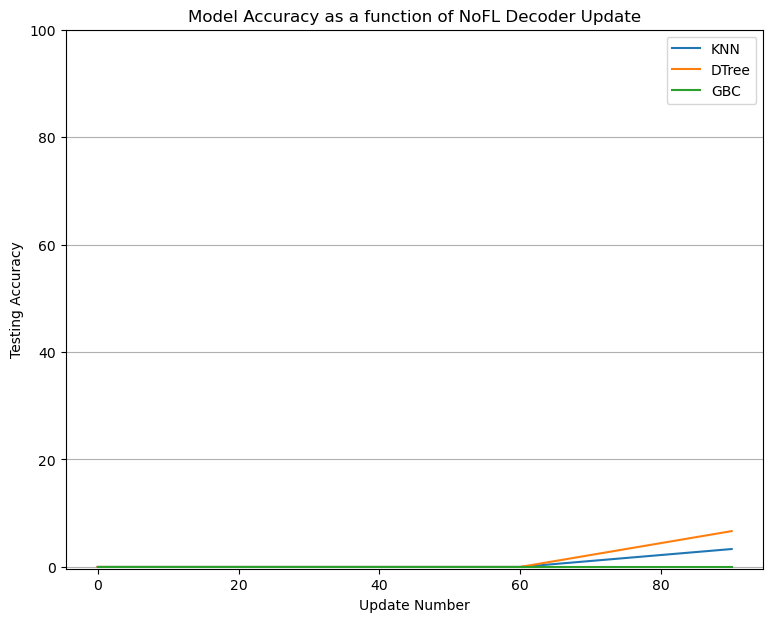

In [92]:
full_test_res_df = cpfa_local_res_df

knn_df = full_test_res_df[full_test_res_df['Adversarial Model']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Adversarial Model']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Adversarial Model']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Adversarial Model']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [93]:
i_nofl = 4
i_fl = 25

ipfa_local_res_df, ipfa_global_res_df = execute_linkage_attack(ipfa_model_dict, i_modulus=i_fl)
ifa_local_res_df, ifa_global_res_df = execute_linkage_attack(ifa_model_dict, i_modulus=i_fl)
inofl_local_res_df, inofl_global_res_df = execute_linkage_attack(inofl_model_dict, i_modulus=i_nofl)

num updates = 108; max_update 251; avg_num_updates 101
num_updates 108; n_start_stop (0, 108); new n_stop 107
Round i=0 of stop=108
Round i=25 of stop=108
Round i=50 of stop=108
Round i=75 of stop=108
Round i=100 of stop=108
num_updates 108; n_start_stop (0, 108); new n_stop 107
Round i=0 of stop=108
Round i=25 of stop=108
Round i=50 of stop=108
Round i=75 of stop=108
Round i=100 of stop=108
num updates = 108; max_update 251; avg_num_updates 101
num_updates 108; n_start_stop (0, 108); new n_stop 107
Round i=0 of stop=108
Round i=25 of stop=108
Round i=50 of stop=108
Round i=75 of stop=108
Round i=100 of stop=108
num_updates 108; n_start_stop (0, 108); new n_stop 107
Round i=0 of stop=108
Round i=25 of stop=108
Round i=50 of stop=108
Round i=75 of stop=108
Round i=100 of stop=108
num updates = 13; max_update 13; avg_num_updates 11.285714285714286
num_updates 13; n_start_stop (0, 13); new n_stop 12
Round i=0 of stop=13
Round i=4 of stop=13
Round i=8 of stop=13
Round i=12 of stop=13
num_u

ValueError: Found array with 0 sample(s) (shape=(0, 128)) while a minimum of 1 is required by KNeighborsClassifier.

In [ ]:
if False:
    cpfa_local_res_df, cpfa_global_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)
    cfa_local_res_df, cfa_global_res_df = execute_linkage_attack(cfa_model_dict, i_modulus=i_fl)
    cnofl_local_res_df, cnofl_global_res_df = execute_linkage_attack(cnofl_model_dict, i_modulus=i_nofl)

    cpfa_local_res_df.to_pickle("cpfa_local_res_df.pkl")
    cpfa_global_res_df.to_pickle("cpfa_global_res_df.pkl")
    cfa_local_res_df.to_pickle("cfa_local_res_df.pkl")
    cfa_global_res_df.to_pickle("cfa_global_res_df.pkl")
    cnofl_local_res_df.to_pickle("cnofl_local_res_df.pkl")
    cnofl_global_res_df.to_pickle("cnofl_global_res_df.pkl")

In [108]:
if False:
    ipfa_local_res_df.to_pickle("ipfa_local_res_df.pkl")
    ipfa_global_res_df.to_pickle("ipfa_global_res_df.pkl")
    ifa_local_res_df.to_pickle("ifa_local_res_df.pkl")
    ifa_global_res_df.to_pickle("ifa_global_res_df.pkl")
    inofl_local_res_df.to_pickle("inofl_local_res_df.pkl")
    inofl_global_res_df.to_pickle("inofl_global_res_df.pkl")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of local and global dataframes
local_dfs = [ipfa_local_res_df, ifa_local_res_df, inofl_local_res_df, cpfa_local_res_df, cfa_local_res_df, cnofl_local_res_df]
global_dfs = [ipfa_global_res_df, ifa_global_res_df, inofl_global_res_df, cpfa_global_res_df, cfa_global_res_df, cnofl_global_res_df]

# Combine all dataframes and filter by 'KNeighborsClassifier'
filtered_dfs = []
for local_df, global_df in zip(local_dfs, global_dfs):
    # Filter for KNeighborsClassifier in each dataframe
    local_filtered = local_df[local_df['Adversarial Model'] == 'KNeighborsClassifier']
    global_filtered = global_df[global_df['Adversarial Model'] == 'KNeighborsClassifier']
    
    # Append both filtered dataframes to a combined list
    filtered_dfs.append(local_filtered)
    filtered_dfs.append(global_filtered)

# Concatenate all filtered dataframes
combined_df = pd.concat(filtered_dfs)

### 1. LINE PLOT
plt.figure(figsize=(10, 7))

# Define unique colors for trials (6 trials, local and global)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
line_styles = ['-', '--']  # Solid for local, dashed for global

# Plot the local and global models with different line styles
for idx, df in enumerate(local_dfs):
    local_filtered = df[df['Adversarial Model'] == 'KNeighborsClassifier']
    global_filtered = global_dfs[idx][global_dfs[idx]['Adversarial Model'] == 'KNeighborsClassifier']
    
    plt.plot(local_filtered['Update Number'], local_filtered['Test Acc'], color=colors[idx], linestyle=line_styles[0], label=f'Trial {idx+1} Local')
    plt.plot(global_filtered['Update Number'], global_filtered['Test Acc'], color=colors[idx], linestyle=line_styles[1], label=f'Trial {idx+1} Global')

plt.xlabel('Update Number')
plt.ylabel('Test Accuracy (%)')
plt.title('KNN Adversarial Model Accuracy Progression')
plt.grid(True)
plt.legend(loc='best')
plt.show()

### 2. HEATMAP

# To create a heatmap, we need a pivoted dataframe where rows represent trials (local and global) and columns are Update Number

# Add a column to represent the trial name
for idx, (local_df, global_df) in enumerate(zip(local_dfs, global_dfs)):
    local_dfs[idx]['Trial'] = f'Trial {idx+1} Local'
    global_dfs[idx]['Trial'] = f'Trial {idx+1} Global'

# Combine all dataframes again with the new 'Trial' column
heatmap_df = pd.concat(local_dfs + global_dfs)

# Filter for KNeighborsClassifier and pivot the dataframe
heatmap_df = heatmap_df[heatmap_df['Adversarial Model'] == 'KNeighborsClassifier']
heatmap_pivot = heatmap_df.pivot(index='Trial', columns='Update Number', values='Test Acc')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Test Accuracy (%)'})
plt.title('KNN Adversarial Model Accuracy Heatmap')
plt.xlabel('Update Number')
plt.ylabel('Trial')
plt.show()


In [20]:
cpfa_res_df.tail()

,Algorithm,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,50,0.523810,0.135135
8,GradientBoostingClassifier,50,0.559524,0.148649
9,KNeighborsClassifier,75,0.714286,0.054054
10,DecisionTreeClassifier,75,0.547619,0.148649
11,GradientBoostingClassifier,75,0.726190,0.135135


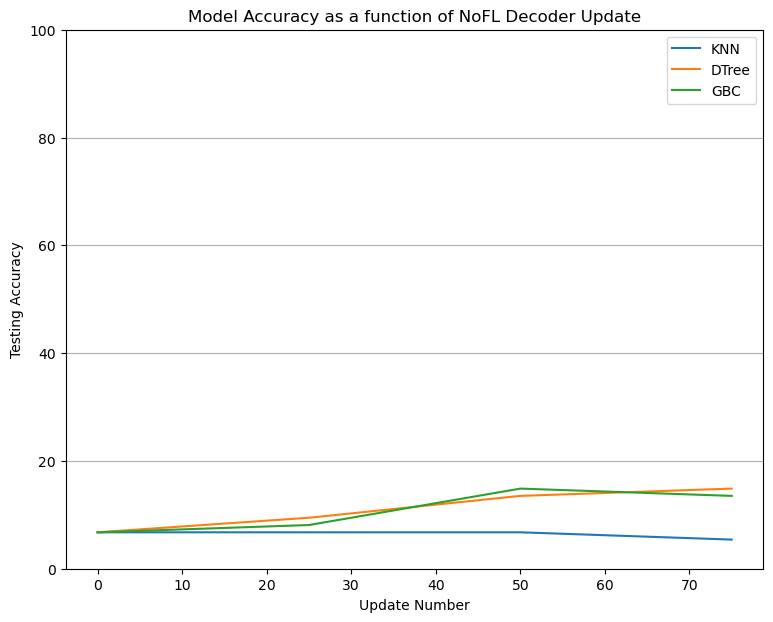

In [21]:
full_test_res_df = cpfa_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [19]:
cfa_res_df.tail()

,Algorithm,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,50,0.345238,0.000000
8,GradientBoostingClassifier,50,0.440476,0.081081
9,KNeighborsClassifier,75,0.535714,0.081081
10,DecisionTreeClassifier,75,0.511905,0.094595
11,GradientBoostingClassifier,75,0.619048,0.135135


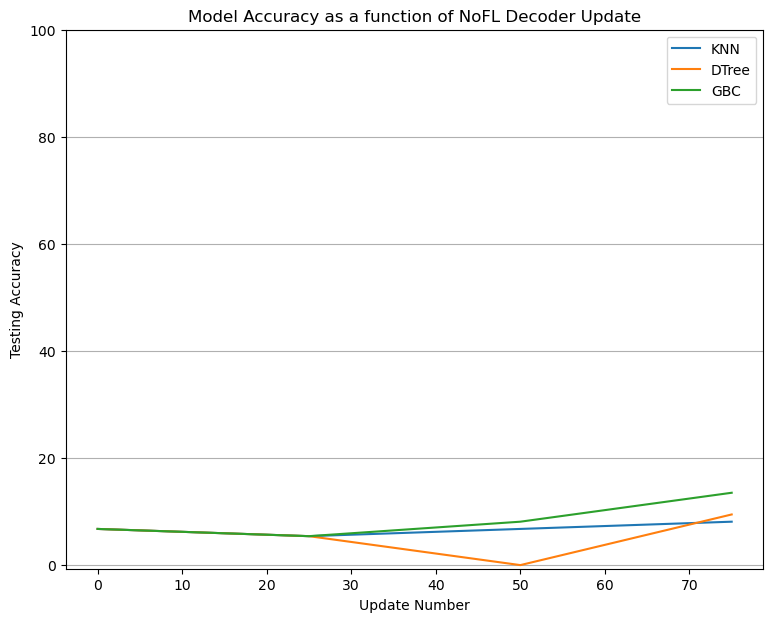

In [23]:
full_test_res_df = cfa_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [18]:
cnofl_res_df.tail()

,Algorithm,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,8,1.0,0.214286
8,GradientBoostingClassifier,8,1.0,0.285714
9,KNeighborsClassifier,12,1.0,1.000000
10,DecisionTreeClassifier,12,1.0,1.000000
11,GradientBoostingClassifier,12,1.0,1.000000


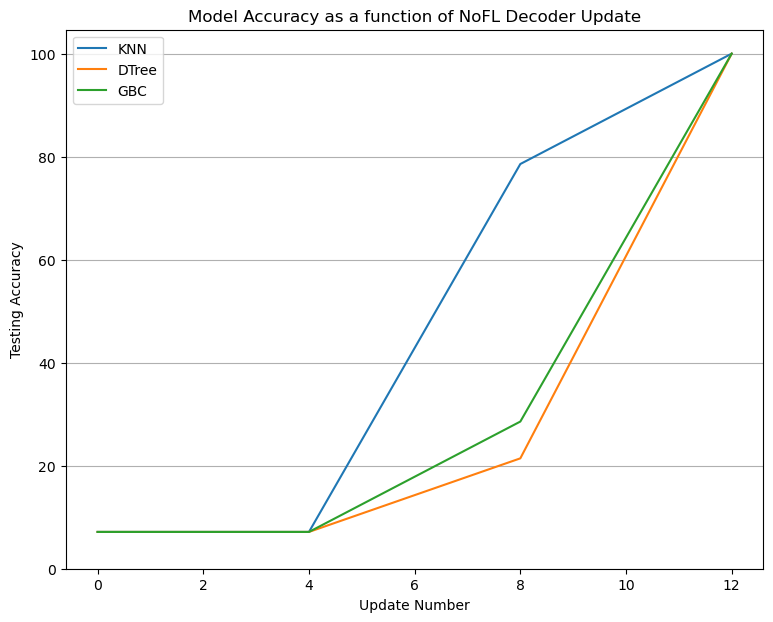

In [24]:
full_test_res_df = cnofl_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [17]:
ipfa_res_df.tail()

,Algorithm,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,50,0.500000,0.190476
8,GradientBoostingClassifier,50,0.500000,0.119048
9,KNeighborsClassifier,75,0.282051,0.166667
10,DecisionTreeClassifier,75,0.421376,0.428571
11,GradientBoostingClassifier,75,0.565803,0.142857


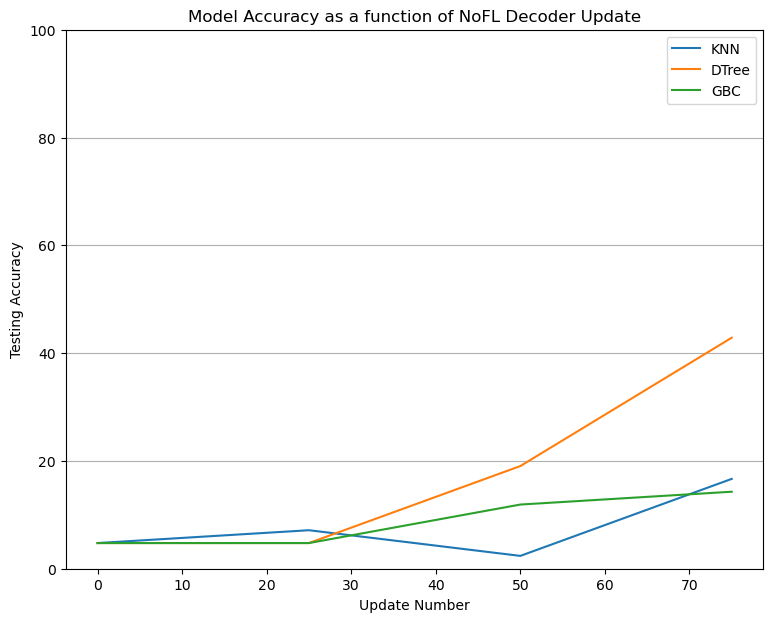

In [25]:
full_test_res_df = ipfa_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [16]:
ifa_res_df.tail()

,Algorithm,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,50,0.469388,0.047619
8,GradientBoostingClassifier,50,0.459184,0.047619
9,KNeighborsClassifier,75,0.407117,0.261905
10,DecisionTreeClassifier,75,0.473182,0.166667
11,GradientBoostingClassifier,75,0.502093,0.214286


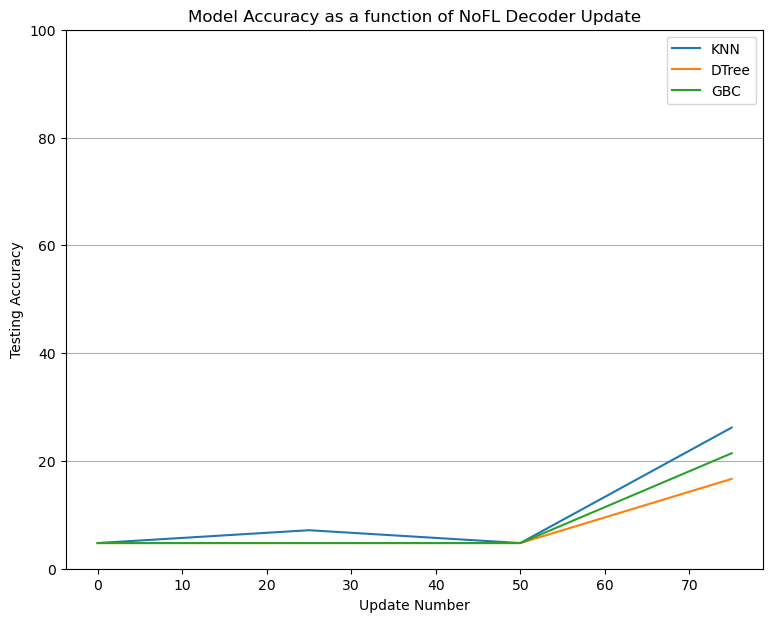

In [26]:
full_test_res_df = ifa_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [15]:
inofl_res_df.tail()

,Algorithm,Update Number,CV Acc,Test Acc
7,DecisionTreeClassifier,8,0.867347,0.142857
8,GradientBoostingClassifier,8,0.969388,0.193878
9,KNeighborsClassifier,12,0.959184,0.959184
10,DecisionTreeClassifier,12,0.846939,0.877551
11,GradientBoostingClassifier,12,0.938776,0.938776


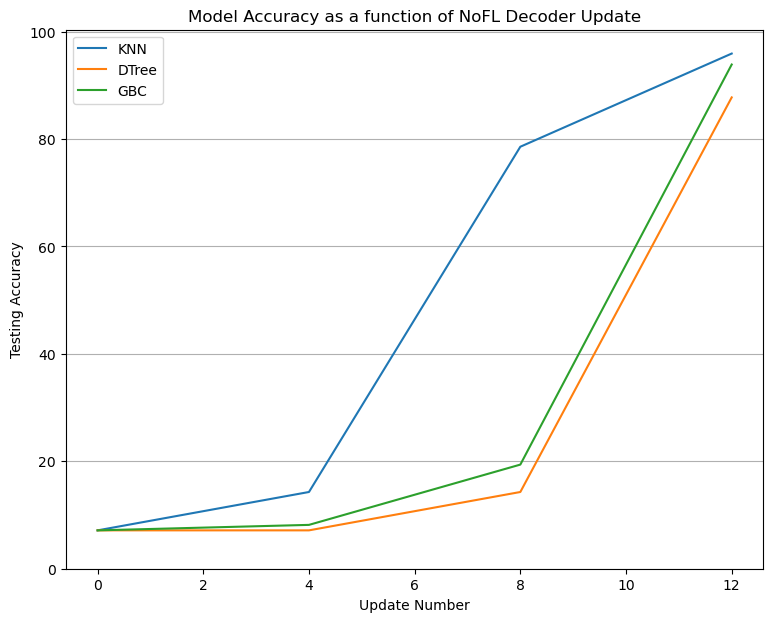

In [27]:
full_test_res_df = inofl_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

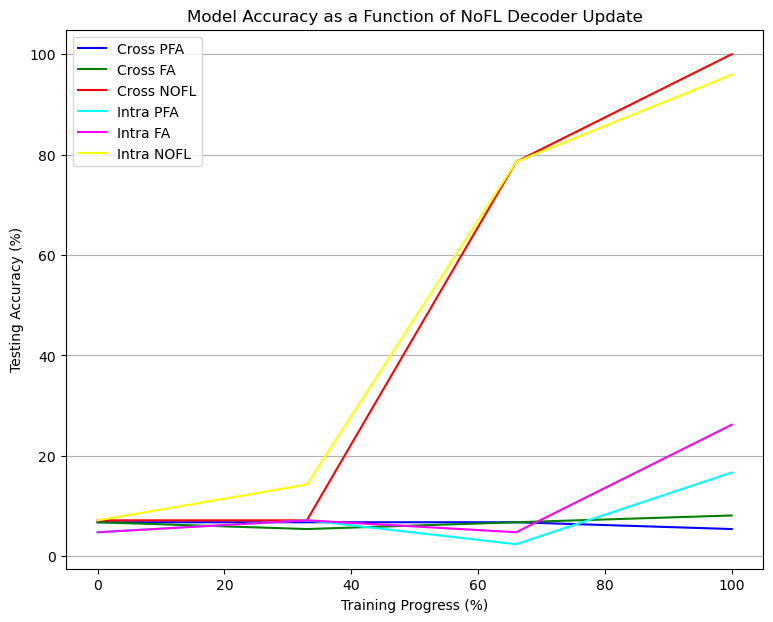

In [47]:

trial_dfs = [cpfa_res_df, cfa_res_df, cnofl_res_df, ipfa_res_df, ifa_res_df, inofl_res_df]  # Replace these with your actual dataframes

# Model names and corresponding colors
models = ['KNeighborsClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
labels = ['Cross PFA', 'Cross FA', 'Cross NOFL', 'Intra PFA', 'Intra FA', 'Intra NOFL']

plt.figure(figsize=(9, 7))

# Loop through each trial dataframe and model to plot all curves
for trial_idx, trial_df in enumerate(trial_dfs):
    # Filter the dataframe for each model (Algorithm)
    model_df = trial_df[trial_df['Algorithm'] == models[0]]
    
    # Plot the curve for this trial and model
    plt.plot(
        [int(ele*100) for ele in model_df['Update Number'] / max(model_df['Update Number'])],
        model_df['Test Acc']*100, 
        label=f'{labels[trial_idx]}', 
        color=colors[trial_idx],
        linestyle='-',  # Solid lines for consistency
        linewidth=1.5
    )

# Customize plot appearance
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Training Progress (%)')
plt.ylabel('Testing Accuracy (%)')
plt.title('Model Accuracy as a Function of NoFL Decoder Update')
plt.legend(loc='best')  # , ncol=2 Adjust the number of columns to avoid overlapping labels
plt.show()


In [13]:
# THESE ARE CREATED ABOVE!
# CROSS
#cpfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
#cfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold')
#cnofl_model_dict = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
#ipfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
#ifa_model_dict = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold')
#inofl_model_dict = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold')

i_nofl = 2
i_fl = 10

full_test_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(cfa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(cnofl_model_dict, i_modulus=i_nofl)
full_test_res_df = execute_linkage_attack(ipfa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(ifa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(inofl_model_dict, i_modulus=i_nofl)



Round i=0 of stop=13
Round i=1 of stop=13
1 skipped for speed!
Round i=2 of stop=13
2 skipped for speed!
Round i=3 of stop=13
Round i=4 of stop=13
4 skipped for speed!
Round i=5 of stop=13
5 skipped for speed!
Round i=6 of stop=13
Round i=7 of stop=13
7 skipped for speed!
Round i=8 of stop=13
8 skipped for speed!
Round i=9 of stop=13
Round i=10 of stop=13
10 skipped for speed!
Round i=11 of stop=13
11 skipped for speed!
Round i=12 of stop=13


In [14]:
full_test_res_df

,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.071429
1,DecisionTreeClassifier,0,0.071429,0.071429
2,GradientBoostingClassifier,0,0.071429,0.071429
3,KNeighborsClassifier,3,1.000000,0.081633
4,DecisionTreeClassifier,3,0.928571,0.081633
5,GradientBoostingClassifier,3,0.989796,0.071429
6,KNeighborsClassifier,6,1.000000,0.346939
7,DecisionTreeClassifier,6,0.918367,0.071429
8,GradientBoostingClassifier,6,0.979592,0.071429
9,KNeighborsClassifier,9,0.969388,0.959184


In [15]:
knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

In [16]:
print(knn_df.shape)
knn_df.head()

(5, 4)


,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.071429
3,KNeighborsClassifier,3,1.000000,0.081633
6,KNeighborsClassifier,6,1.000000,0.346939
9,KNeighborsClassifier,9,0.969388,0.959184
12,KNeighborsClassifier,12,0.959184,0.959184


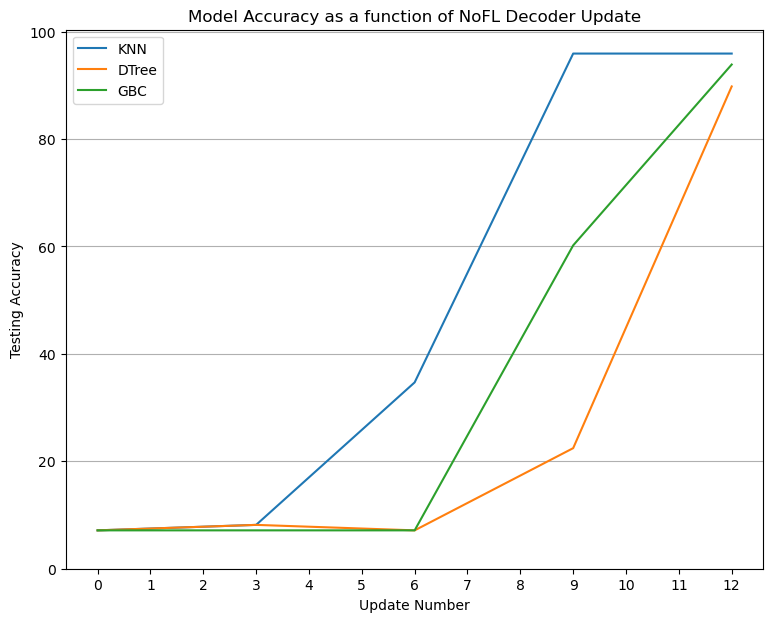

In [17]:
col_num = 1
my_x_updates = list(range(17))

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [ ]:
# CONDUCT GLOBAL MODEL ANALYSIS TOO!